In [5]:
from perso import *
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import skimage.io
import warnings
warnings.filterwarnings("ignore")

In [2]:
class ImageIterator():
    def __init__(self, path, batch_size=32, shuffle = False, ext = '.png', max_n = 9999999):
        self.batch_size = batch_size
        self.path = path
        self.shuffle = shuffle
        self._n = 0
        self.max_n = getLastFromDir(path)
        if self.max_n > max_n: self.max_n = max_n
        self.ext = ext
        self.epochs = 0
    
    def __next__(self):
        data = []
        for x in range(self.batch_size):
            img = skimage.io.imread(self.path+'/{}'.format(self._n)+self.ext)
            img = (img - 127.5) / 127.5
            data.append(img)
            self._n +=1
            if self._n > self.max_n: 
                self._n = 0
                self.epochs += 1
        return np.asarray(data)
class SiameseGanImageIterator():
    def __init__(self,generator, back_path, persons_path, batch_size= 16,**kwargs):
        
        self.back_path = back_path
        self.persons_path = persons_path 
        
        self.max_n = min(getLastFromDir(back_path), getLastFromDir(persons_path))
        self.generator = generator
        self.batch_size = batch_size
        self._n = 0
        self.ext = '.png'
    
    def add_n(self):
        self._n += 1 
        if self._n > self.max_n:
            self._n = 0
        
    def next(self):
        backs = []
        persons = []
        for x in range(self.batch_size):
            while True:
                try:
                    back = (skimage.io.imread(self.back_path+'/{}'.format(self._n)+self.ext) -127.5) / 127.5
                    person = (skimage.io.imread(self.persons_path+'/{}'.format(self._n)+self.ext) - 127.5) / 127.5
                    break
                except: self.add_n()
            backs.append(back)
            persons.append(person)
            self.add_n()
        return np.asarray(persons), np.asarray(backs)
            
        
    def get_valid_imgs(self):
        persons, backs = self.next()
        return [persons, backs]
    
    def get_fake_imgs(self):
        persons, backs = self.next()
        persons = self.generator.predict(backs)
        return [persons, backs]
    

In [3]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 640
        self.img_cols = 640
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'nude'


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)
        #self.combined_dressed = Model(inputs=img_B, outputs=valid)
        #self.combined_dressed.compile(loss='mae', optimizer=optimizer)
        
        
        print(self.generator.summary())
        print(self.discriminator.summary())
        print(self.combined.summary())
        
    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True, strides=2):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0, size=2):
            """Layers used during upsampling"""
            u = UpSampling2D(size=size)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)
        
        """d5 = d_layer(combined_imgs, self.df, bn=False, f_size=2)
        d6 = d_layer(d5, self.df*2, f_size=2)
        d7 = d_layer(d6, self.df*4, f_size=2)
        d8 = d_layer(d7, self.df*8, f_size=2)
        
        d = Concatenate(axis=-1)([d4, d8])"""
        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        self.iterator = SiameseGanImageIterator(self.generator, 'data/640x640/cropped/nude/face', 
                                                'data/640x640/cropped/nude/person', batch_size = batch_size)

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        steps_per_epoch = int(self.iterator.max_n / batch_size)
        print(steps_per_epoch)
        for epoch in range(epochs):
            for s in range(steps_per_epoch):

                # ---------------------
                #  Train Discriminator
                # ---------------------
                valid_imgs = self.iterator.get_valid_imgs()
                fake_imgs = self.iterator.get_fake_imgs()
                d_loss_real = self.discriminator.train_on_batch(valid_imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(fake_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                g_loss = self.combined.train_on_batch(valid_imgs, [valid, valid_imgs[0]])
                #valid_imgs = self.iterator.get_dressed_imgs()
                #g_loss_dressed = self.combined_dressed.train_on_batch(valid_imgs[1], valid)
                #g_loss = 0.5 * np.add(g_loss_nude, g_loss_dressed)
                

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        s, steps_per_epoch,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if s % sample_interval == 0:
                    self.sample_images(epoch)

    def sample_images(self, epoch):
        print('sampling')
        valids = self.iterator.get_valid_imgs()
        back = valids[1]
        truth = valids[0]
        generated = self.generator.predict(back)[0]
        img = show_encoded_array(np.concatenate([back[0],generated, truth[0]], axis=1))
        img.save('sample/{}.png'.format(epoch))


In [4]:
K.clear_session()
gan = Pix2Pix()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 320, 320, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 320, 320, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 160, 160, 128 131200      leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
leaky_re_l

/home/jean/anaconda3/envs/kerasenv/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
gan.train(epochs=200, batch_size=4, sample_interval=200)

1367
[Epoch 0/200] [Batch 0/1367] [D loss: 22.637815, acc:  22%] [G loss: 128.505127] time: 0:00:22.772950
sampling
[Epoch 0/200] [Batch 1/1367] [D loss: 23.409107, acc:   5%] [G loss: 59.379639] time: 0:00:28.659630
[Epoch 0/200] [Batch 2/1367] [D loss: 17.193813, acc:   7%] [G loss: 54.358345] time: 0:00:33.146419
[Epoch 0/200] [Batch 3/1367] [D loss: 7.773759, acc:   9%] [G loss: 46.856621] time: 0:00:37.654842
[Epoch 0/200] [Batch 4/1367] [D loss: 2.599147, acc:  13%] [G loss: 34.961414] time: 0:00:42.131064
[Epoch 0/200] [Batch 5/1367] [D loss: 1.096805, acc:  36%] [G loss: 30.236580] time: 0:00:46.611550
[Epoch 0/200] [Batch 6/1367] [D loss: 0.755301, acc:  43%] [G loss: 31.747610] time: 0:00:51.099247
[Epoch 0/200] [Batch 7/1367] [D loss: 0.626936, acc:  47%] [G loss: 22.930212] time: 0:00:55.586290
[Epoch 0/200] [Batch 8/1367] [D loss: 0.573940, acc:  46%] [G loss: 25.649952] time: 0:01:00.081318
[Epoch 0/200] [Batch 9/1367] [D loss: 0.533100, acc:  49%] [G loss: 29.641657] tim

[Epoch 0/200] [Batch 82/1367] [D loss: 0.319428, acc:  38%] [G loss: 13.850019] time: 0:06:37.953496
[Epoch 0/200] [Batch 83/1367] [D loss: 0.240091, acc:  75%] [G loss: 13.174192] time: 0:06:42.538977
[Epoch 0/200] [Batch 84/1367] [D loss: 0.240179, acc:  71%] [G loss: 14.927591] time: 0:06:47.121509
[Epoch 0/200] [Batch 85/1367] [D loss: 0.345234, acc:  44%] [G loss: 22.199867] time: 0:06:51.745876
[Epoch 0/200] [Batch 86/1367] [D loss: 0.331913, acc:  44%] [G loss: 20.853296] time: 0:06:56.346605
[Epoch 0/200] [Batch 87/1367] [D loss: 0.283995, acc:  70%] [G loss: 14.193029] time: 0:07:00.948589
[Epoch 0/200] [Batch 88/1367] [D loss: 0.346637, acc:  22%] [G loss: 19.257807] time: 0:07:05.572764
[Epoch 0/200] [Batch 89/1367] [D loss: 0.245552, acc:  60%] [G loss: 20.076326] time: 0:07:10.166843
[Epoch 0/200] [Batch 90/1367] [D loss: 0.295564, acc:  51%] [G loss: 10.743284] time: 0:07:14.796531
[Epoch 0/200] [Batch 91/1367] [D loss: 0.325827, acc:  26%] [G loss: 12.163098] time: 0:07:

[Epoch 0/200] [Batch 163/1367] [D loss: 0.316149, acc:  58%] [G loss: 14.392893] time: 0:12:49.307352
[Epoch 0/200] [Batch 164/1367] [D loss: 0.333653, acc:  22%] [G loss: 14.897768] time: 0:12:53.879871
[Epoch 0/200] [Batch 165/1367] [D loss: 0.252498, acc:  64%] [G loss: 7.832727] time: 0:12:58.458907
[Epoch 0/200] [Batch 166/1367] [D loss: 0.270311, acc:  65%] [G loss: 9.152681] time: 0:13:03.014885
[Epoch 0/200] [Batch 167/1367] [D loss: 0.233377, acc:  55%] [G loss: 10.176543] time: 0:13:07.593596
[Epoch 0/200] [Batch 168/1367] [D loss: 0.299023, acc:  47%] [G loss: 14.613612] time: 0:13:12.188128
[Epoch 0/200] [Batch 169/1367] [D loss: 0.216326, acc:  83%] [G loss: 10.442964] time: 0:13:16.755574
[Epoch 0/200] [Batch 170/1367] [D loss: 0.277350, acc:  35%] [G loss: 10.071964] time: 0:13:21.342910
[Epoch 0/200] [Batch 171/1367] [D loss: 0.280505, acc:  35%] [G loss: 8.754486] time: 0:13:25.937541
[Epoch 0/200] [Batch 172/1367] [D loss: 0.245427, acc:  38%] [G loss: 7.535445] time:

[Epoch 0/200] [Batch 244/1367] [D loss: 0.267674, acc:  33%] [G loss: 6.790002] time: 0:19:01.288771
[Epoch 0/200] [Batch 245/1367] [D loss: 0.259138, acc:  52%] [G loss: 15.767702] time: 0:19:05.881109
[Epoch 0/200] [Batch 246/1367] [D loss: 0.228579, acc:  74%] [G loss: 6.083947] time: 0:19:10.455341
[Epoch 0/200] [Batch 247/1367] [D loss: 0.241541, acc:  71%] [G loss: 9.383999] time: 0:19:15.022820
[Epoch 0/200] [Batch 248/1367] [D loss: 0.278420, acc:  64%] [G loss: 11.497594] time: 0:19:19.590226
[Epoch 0/200] [Batch 249/1367] [D loss: 0.275877, acc:  51%] [G loss: 11.048237] time: 0:19:24.140961
[Epoch 0/200] [Batch 250/1367] [D loss: 0.244482, acc:  61%] [G loss: 13.091981] time: 0:19:28.719792
[Epoch 0/200] [Batch 251/1367] [D loss: 0.223923, acc:  63%] [G loss: 13.326828] time: 0:19:33.314964
[Epoch 0/200] [Batch 252/1367] [D loss: 0.299003, acc:  30%] [G loss: 12.909592] time: 0:19:37.870681
[Epoch 0/200] [Batch 253/1367] [D loss: 0.246620, acc:  41%] [G loss: 8.929177] time:

[Epoch 0/200] [Batch 325/1367] [D loss: 0.326539, acc:  35%] [G loss: 13.931264] time: 0:25:11.931440
[Epoch 0/200] [Batch 326/1367] [D loss: 0.348671, acc:  31%] [G loss: 11.740917] time: 0:25:16.489312
[Epoch 0/200] [Batch 327/1367] [D loss: 0.274197, acc:  40%] [G loss: 8.092691] time: 0:25:21.070484
[Epoch 0/200] [Batch 328/1367] [D loss: 0.258818, acc:  54%] [G loss: 9.121635] time: 0:25:25.683067
[Epoch 0/200] [Batch 329/1367] [D loss: 0.235704, acc:  61%] [G loss: 6.775208] time: 0:25:30.234294
[Epoch 0/200] [Batch 330/1367] [D loss: 0.206312, acc:  72%] [G loss: 8.665713] time: 0:25:34.812078
[Epoch 0/200] [Batch 331/1367] [D loss: 0.329946, acc:  67%] [G loss: 13.280827] time: 0:25:39.394583
[Epoch 0/200] [Batch 332/1367] [D loss: 0.382868, acc:  61%] [G loss: 10.750318] time: 0:25:43.983359
[Epoch 0/200] [Batch 333/1367] [D loss: 0.338246, acc:  63%] [G loss: 9.674364] time: 0:25:48.564069
[Epoch 0/200] [Batch 334/1367] [D loss: 0.444545, acc:  57%] [G loss: 11.686063] time: 

[Epoch 0/200] [Batch 406/1367] [D loss: 0.245213, acc:  72%] [G loss: 8.827468] time: 0:31:24.307722
[Epoch 0/200] [Batch 407/1367] [D loss: 0.210905, acc:  79%] [G loss: 5.861099] time: 0:31:28.843992
[Epoch 0/200] [Batch 408/1367] [D loss: 0.243526, acc:  51%] [G loss: 3.269996] time: 0:31:33.385069
[Epoch 0/200] [Batch 409/1367] [D loss: 0.128901, acc:  93%] [G loss: 5.589230] time: 0:31:37.932920
[Epoch 0/200] [Batch 410/1367] [D loss: 0.145992, acc:  79%] [G loss: 10.963527] time: 0:31:42.511890
[Epoch 0/200] [Batch 411/1367] [D loss: 0.119609, acc:  85%] [G loss: 4.380083] time: 0:31:47.084238
[Epoch 0/200] [Batch 412/1367] [D loss: 0.165220, acc:  80%] [G loss: 8.157821] time: 0:31:51.634656
[Epoch 0/200] [Batch 413/1367] [D loss: 0.132566, acc:  93%] [G loss: 13.727651] time: 0:31:56.207085
[Epoch 0/200] [Batch 414/1367] [D loss: 0.215682, acc:  52%] [G loss: 9.784692] time: 0:32:00.778471
[Epoch 0/200] [Batch 415/1367] [D loss: 0.116822, acc:  91%] [G loss: 9.465447] time: 0:3

[Epoch 0/200] [Batch 487/1367] [D loss: 0.130568, acc:  88%] [G loss: 6.475601] time: 0:37:34.736685
[Epoch 0/200] [Batch 488/1367] [D loss: 0.229711, acc:  60%] [G loss: 12.080954] time: 0:37:39.254679
[Epoch 0/200] [Batch 489/1367] [D loss: 0.055878, acc:  98%] [G loss: 11.749264] time: 0:37:43.824278
[Epoch 0/200] [Batch 490/1367] [D loss: 0.088360, acc:  93%] [G loss: 11.994170] time: 0:37:48.404693
[Epoch 0/200] [Batch 491/1367] [D loss: 0.098916, acc:  87%] [G loss: 8.931896] time: 0:37:52.976324
[Epoch 0/200] [Batch 492/1367] [D loss: 0.129810, acc:  93%] [G loss: 12.212940] time: 0:37:57.577831
[Epoch 0/200] [Batch 493/1367] [D loss: 0.132177, acc:  92%] [G loss: 8.654303] time: 0:38:02.140359
[Epoch 0/200] [Batch 494/1367] [D loss: 0.198548, acc:  83%] [G loss: 10.283794] time: 0:38:06.700102
[Epoch 0/200] [Batch 495/1367] [D loss: 0.693244, acc:  45%] [G loss: 12.766890] time: 0:38:11.275487
[Epoch 0/200] [Batch 496/1367] [D loss: 0.196056, acc:  77%] [G loss: 19.372169] time

[Epoch 0/200] [Batch 568/1367] [D loss: 0.333642, acc:  30%] [G loss: 12.217206] time: 0:43:45.173229
[Epoch 0/200] [Batch 569/1367] [D loss: 0.086744, acc:  94%] [G loss: 17.576910] time: 0:43:49.796776
[Epoch 0/200] [Batch 570/1367] [D loss: 0.200946, acc:  74%] [G loss: 13.995552] time: 0:43:54.394248
[Epoch 0/200] [Batch 571/1367] [D loss: 0.193306, acc:  78%] [G loss: 10.184498] time: 0:43:59.005567
[Epoch 0/200] [Batch 572/1367] [D loss: 0.105780, acc:  94%] [G loss: 11.059899] time: 0:44:03.568973
[Epoch 0/200] [Batch 573/1367] [D loss: 0.113235, acc:  95%] [G loss: 9.558752] time: 0:44:08.141264
[Epoch 0/200] [Batch 574/1367] [D loss: 0.105472, acc:  92%] [G loss: 8.509269] time: 0:44:12.708854
[Epoch 0/200] [Batch 575/1367] [D loss: 0.209527, acc:  71%] [G loss: 10.963487] time: 0:44:17.281842
[Epoch 0/200] [Batch 576/1367] [D loss: 0.300115, acc:  59%] [G loss: 11.574969] time: 0:44:21.859127
[Epoch 0/200] [Batch 577/1367] [D loss: 0.207988, acc:  56%] [G loss: 7.736421] time

[Epoch 0/200] [Batch 649/1367] [D loss: 0.143249, acc:  94%] [G loss: 10.803240] time: 0:49:56.585741
[Epoch 0/200] [Batch 650/1367] [D loss: 0.067887, acc:  93%] [G loss: 8.171731] time: 0:50:01.147387
[Epoch 0/200] [Batch 651/1367] [D loss: 0.092081, acc:  90%] [G loss: 8.670677] time: 0:50:05.685158
[Epoch 0/200] [Batch 652/1367] [D loss: 0.022622, acc:  99%] [G loss: 6.104499] time: 0:50:10.229344
[Epoch 0/200] [Batch 653/1367] [D loss: 0.104663, acc:  90%] [G loss: 7.902576] time: 0:50:14.805951
[Epoch 0/200] [Batch 654/1367] [D loss: 0.195434, acc:  62%] [G loss: 8.872333] time: 0:50:19.381372
[Epoch 0/200] [Batch 655/1367] [D loss: 0.068429, acc:  97%] [G loss: 7.354537] time: 0:50:23.926797
[Epoch 0/200] [Batch 656/1367] [D loss: 0.102613, acc:  97%] [G loss: 10.930370] time: 0:50:28.481233
[Epoch 0/200] [Batch 657/1367] [D loss: 0.041448, acc:  99%] [G loss: 7.755072] time: 0:50:33.051924
[Epoch 0/200] [Batch 658/1367] [D loss: 0.037407, acc:  97%] [G loss: 6.729511] time: 0:5

[Epoch 0/200] [Batch 730/1367] [D loss: 0.046834, acc:  96%] [G loss: 11.810978] time: 0:56:07.222988
[Epoch 0/200] [Batch 731/1367] [D loss: 0.153238, acc:  79%] [G loss: 7.656672] time: 0:56:11.784805
[Epoch 0/200] [Batch 732/1367] [D loss: 0.088863, acc:  93%] [G loss: 7.165671] time: 0:56:16.385646
[Epoch 0/200] [Batch 733/1367] [D loss: 0.301287, acc:  30%] [G loss: 7.171086] time: 0:56:20.917353
[Epoch 0/200] [Batch 734/1367] [D loss: 0.293797, acc:  42%] [G loss: 10.768455] time: 0:56:25.488218
[Epoch 0/200] [Batch 735/1367] [D loss: 0.054071, acc:  97%] [G loss: 12.920713] time: 0:56:30.064470
[Epoch 0/200] [Batch 736/1367] [D loss: 0.082236, acc:  91%] [G loss: 10.076685] time: 0:56:34.636031
[Epoch 0/200] [Batch 737/1367] [D loss: 0.143069, acc:  86%] [G loss: 13.406970] time: 0:56:39.202038
[Epoch 0/200] [Batch 738/1367] [D loss: 0.164057, acc:  68%] [G loss: 9.607676] time: 0:56:43.758449
[Epoch 0/200] [Batch 739/1367] [D loss: 0.247062, acc:  80%] [G loss: 8.475098] time: 

[Epoch 0/200] [Batch 811/1367] [D loss: 0.227450, acc:  63%] [G loss: 10.556965] time: 1:02:19.207272
[Epoch 0/200] [Batch 812/1367] [D loss: 0.086290, acc:  96%] [G loss: 6.520485] time: 1:02:23.768812
[Epoch 0/200] [Batch 813/1367] [D loss: 0.055718, acc:  92%] [G loss: 8.823896] time: 1:02:28.333468
[Epoch 0/200] [Batch 814/1367] [D loss: 0.596462, acc:  54%] [G loss: 11.422032] time: 1:02:32.906576
[Epoch 0/200] [Batch 815/1367] [D loss: 0.097750, acc:  88%] [G loss: 10.720890] time: 1:02:37.481794
[Epoch 0/200] [Batch 816/1367] [D loss: 0.063080, acc:  94%] [G loss: 13.070192] time: 1:02:42.047647
[Epoch 0/200] [Batch 817/1367] [D loss: 0.020470, acc:  99%] [G loss: 12.887744] time: 1:02:46.661109
[Epoch 0/200] [Batch 818/1367] [D loss: 0.066837, acc:  93%] [G loss: 10.340428] time: 1:02:51.250211
[Epoch 0/200] [Batch 819/1367] [D loss: 0.063597, acc:  98%] [G loss: 5.823801] time: 1:02:55.794394
[Epoch 0/200] [Batch 820/1367] [D loss: 0.033290, acc:  99%] [G loss: 9.168174] time:

[Epoch 0/200] [Batch 892/1367] [D loss: 0.158807, acc:  84%] [G loss: 6.719377] time: 1:08:29.424958
[Epoch 0/200] [Batch 893/1367] [D loss: 0.185842, acc:  75%] [G loss: 6.973210] time: 1:08:33.970088
[Epoch 0/200] [Batch 894/1367] [D loss: 0.132074, acc:  81%] [G loss: 8.476695] time: 1:08:38.537439
[Epoch 0/200] [Batch 895/1367] [D loss: 0.094157, acc:  86%] [G loss: 5.891695] time: 1:08:43.086049
[Epoch 0/200] [Batch 896/1367] [D loss: 0.081309, acc:  90%] [G loss: 7.581056] time: 1:08:47.646659
[Epoch 0/200] [Batch 897/1367] [D loss: 0.069234, acc:  94%] [G loss: 8.278257] time: 1:08:52.183590
[Epoch 0/200] [Batch 898/1367] [D loss: 0.157257, acc:  91%] [G loss: 7.282662] time: 1:08:56.722967
[Epoch 0/200] [Batch 899/1367] [D loss: 0.468792, acc:  51%] [G loss: 5.409813] time: 1:09:01.270545
[Epoch 0/200] [Batch 900/1367] [D loss: 0.424215, acc:  53%] [G loss: 6.605793] time: 1:09:05.832979
[Epoch 0/200] [Batch 901/1367] [D loss: 0.249067, acc:  63%] [G loss: 12.432085] time: 1:09

[Epoch 0/200] [Batch 973/1367] [D loss: 0.106009, acc:  85%] [G loss: 13.024168] time: 1:14:40.313054
[Epoch 0/200] [Batch 974/1367] [D loss: 0.053690, acc:  98%] [G loss: 15.270263] time: 1:14:44.887277
[Epoch 0/200] [Batch 975/1367] [D loss: 0.509828, acc:  53%] [G loss: 14.057272] time: 1:14:49.452710
[Epoch 0/200] [Batch 976/1367] [D loss: 0.293413, acc:  42%] [G loss: 10.497435] time: 1:14:54.015199
[Epoch 0/200] [Batch 977/1367] [D loss: 0.214152, acc:  74%] [G loss: 9.411991] time: 1:14:58.579985
[Epoch 0/200] [Batch 978/1367] [D loss: 0.108785, acc:  95%] [G loss: 14.416832] time: 1:15:03.146407
[Epoch 0/200] [Batch 979/1367] [D loss: 0.437717, acc:  49%] [G loss: 10.603339] time: 1:15:07.704168
[Epoch 0/200] [Batch 980/1367] [D loss: 0.337688, acc:  32%] [G loss: 6.371926] time: 1:15:12.241542
[Epoch 0/200] [Batch 981/1367] [D loss: 0.276628, acc:  45%] [G loss: 9.330203] time: 1:15:16.831986
[Epoch 0/200] [Batch 982/1367] [D loss: 0.388271, acc:  38%] [G loss: 8.460641] time:

[Epoch 0/200] [Batch 1054/1367] [D loss: 0.124120, acc:  81%] [G loss: 15.862440] time: 1:20:52.160412
[Epoch 0/200] [Batch 1055/1367] [D loss: 0.059843, acc:  97%] [G loss: 11.776044] time: 1:20:56.743238
[Epoch 0/200] [Batch 1056/1367] [D loss: 0.052443, acc:  97%] [G loss: 10.342655] time: 1:21:01.318634
[Epoch 0/200] [Batch 1057/1367] [D loss: 0.105861, acc:  84%] [G loss: 9.942234] time: 1:21:05.919357
[Epoch 0/200] [Batch 1058/1367] [D loss: 0.047686, acc:  98%] [G loss: 8.974470] time: 1:21:10.486154
[Epoch 0/200] [Batch 1059/1367] [D loss: 0.275151, acc:  38%] [G loss: 11.342820] time: 1:21:15.056283
[Epoch 0/200] [Batch 1060/1367] [D loss: 0.236102, acc:  65%] [G loss: 7.892952] time: 1:21:19.641743
[Epoch 0/200] [Batch 1061/1367] [D loss: 0.241297, acc:  55%] [G loss: 8.827368] time: 1:21:24.205997
[Epoch 0/200] [Batch 1062/1367] [D loss: 0.124510, acc:  86%] [G loss: 8.707329] time: 1:21:28.777189
[Epoch 0/200] [Batch 1063/1367] [D loss: 0.259543, acc:  50%] [G loss: 8.40507

[Epoch 0/200] [Batch 1134/1367] [D loss: 0.593317, acc:  12%] [G loss: 7.914034] time: 1:26:58.004917
[Epoch 0/200] [Batch 1135/1367] [D loss: 0.274641, acc:  46%] [G loss: 8.623729] time: 1:27:02.559090
[Epoch 0/200] [Batch 1136/1367] [D loss: 0.313777, acc:  24%] [G loss: 5.586843] time: 1:27:07.121727
[Epoch 0/200] [Batch 1137/1367] [D loss: 0.305626, acc:  35%] [G loss: 10.691217] time: 1:27:11.698546
[Epoch 0/200] [Batch 1138/1367] [D loss: 0.228334, acc:  65%] [G loss: 15.948476] time: 1:27:16.285867
[Epoch 0/200] [Batch 1139/1367] [D loss: 0.195261, acc:  64%] [G loss: 17.654358] time: 1:27:20.905811
[Epoch 0/200] [Batch 1140/1367] [D loss: 0.198665, acc:  73%] [G loss: 12.071599] time: 1:27:25.488921
[Epoch 0/200] [Batch 1141/1367] [D loss: 0.144124, acc:  79%] [G loss: 11.767385] time: 1:27:30.073050
[Epoch 0/200] [Batch 1142/1367] [D loss: 0.161271, acc:  89%] [G loss: 7.115562] time: 1:27:34.629881
[Epoch 0/200] [Batch 1143/1367] [D loss: 0.028838, acc:  99%] [G loss: 8.6052

[Epoch 0/200] [Batch 1214/1367] [D loss: 0.401436, acc:  31%] [G loss: 10.008895] time: 1:33:05.240295
[Epoch 0/200] [Batch 1215/1367] [D loss: 0.130095, acc:  76%] [G loss: 9.867996] time: 1:33:09.815754
[Epoch 0/200] [Batch 1216/1367] [D loss: 0.054363, acc:  98%] [G loss: 13.818246] time: 1:33:14.379848
[Epoch 0/200] [Batch 1217/1367] [D loss: 0.042394, acc:  97%] [G loss: 15.997311] time: 1:33:18.940079
[Epoch 0/200] [Batch 1218/1367] [D loss: 0.050883, acc:  94%] [G loss: 11.581503] time: 1:33:23.524232
[Epoch 0/200] [Batch 1219/1367] [D loss: 0.047291, acc:  98%] [G loss: 13.951685] time: 1:33:28.096518
[Epoch 0/200] [Batch 1220/1367] [D loss: 0.140148, acc:  75%] [G loss: 10.681619] time: 1:33:32.686602
[Epoch 0/200] [Batch 1221/1367] [D loss: 0.481500, acc:  17%] [G loss: 10.508895] time: 1:33:37.268732
[Epoch 0/200] [Batch 1222/1367] [D loss: 0.194630, acc:  75%] [G loss: 10.923018] time: 1:33:41.833060
[Epoch 0/200] [Batch 1223/1367] [D loss: 0.359147, acc:  49%] [G loss: 7.0

[Epoch 0/200] [Batch 1294/1367] [D loss: 0.035631, acc:  99%] [G loss: 5.590810] time: 1:39:10.942065
[Epoch 0/200] [Batch 1295/1367] [D loss: 0.189077, acc:  81%] [G loss: 8.201765] time: 1:39:15.519189
[Epoch 0/200] [Batch 1296/1367] [D loss: 0.246654, acc:  49%] [G loss: 6.873387] time: 1:39:20.081591
[Epoch 0/200] [Batch 1297/1367] [D loss: 0.144886, acc:  82%] [G loss: 6.256438] time: 1:39:24.658476
[Epoch 0/200] [Batch 1298/1367] [D loss: 0.116262, acc:  86%] [G loss: 5.906776] time: 1:39:29.198762
[Epoch 0/200] [Batch 1299/1367] [D loss: 0.125451, acc:  84%] [G loss: 12.571708] time: 1:39:33.763820
[Epoch 0/200] [Batch 1300/1367] [D loss: 0.163798, acc:  82%] [G loss: 7.805021] time: 1:39:38.331738
[Epoch 0/200] [Batch 1301/1367] [D loss: 0.224852, acc:  57%] [G loss: 6.674045] time: 1:39:42.880669
[Epoch 0/200] [Batch 1302/1367] [D loss: 0.068973, acc:  90%] [G loss: 14.575066] time: 1:39:47.465628
[Epoch 0/200] [Batch 1303/1367] [D loss: 0.123275, acc:  86%] [G loss: 10.490838

In [18]:
iterator = SiameseGanImageIterator(gan.generator, 'data/128x128/cropped/nude/backgrounds', 
                                                'data/128x128/cropped/nude/persons',
                                                'data/128x128/cropped/dressed/backgrounds',
                                                'data/128x128/cropped/dressed/persons',
                                          batch_size = 1)

In [12]:
x, y = iterator.get_valid_imgs()

In [53]:
y.shape

(128, 128, 128, 3)

In [13]:
valids = iterator.get_valid_imgs()

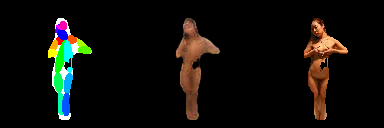

In [28]:
valids = iterator.get_valid_imgs()
back = valids[1]
truth = valids[0]
generated = gan.generator.predict(back)[0]
show_encoded_array(np.concatenate([back[0],generated, truth[0]], axis=1))

In [266]:
backed = generated
for row in range(generated.shape[0]):
    for pix in range(generated.shape[1]):
        if int(generated[row][pix][0]*255) < 0.001 and int(generated[row][pix][1]*255) < 0.001 and int(generated[row][pix][2]*255) < 0.001:
            backed[row][pix] = back[0][row][pix]
    

In [ ]:
gan.generator.load_weights('generator.ckpt')
gan.discriminator.load_weights('discriminator.ckpt')
gan.combined.load_weights('combined.cktp')

In [56]:
gan.generator.save('generator.ckpt')
gan.discriminator.save('discriminator.ckpt')
gan.combined.save('combined.cktp')